Updated Weibo Columns: Index(['评论', 'time', 'sentiment'], dtype='object')
Updated Bilibili Columns: Index(['type', 'text', 'likes', 'time', 'character', 'sentiment'], dtype='object')
Data successfully loaded and processed!


08:58:07 - cmdstanpy - INFO - Chain [1] start processing
08:58:08 - cmdstanpy - INFO - Chain [1] done processing
08:58:08 - cmdstanpy - INFO - Chain [1] start processing
08:58:08 - cmdstanpy - INFO - Chain [1] done processing


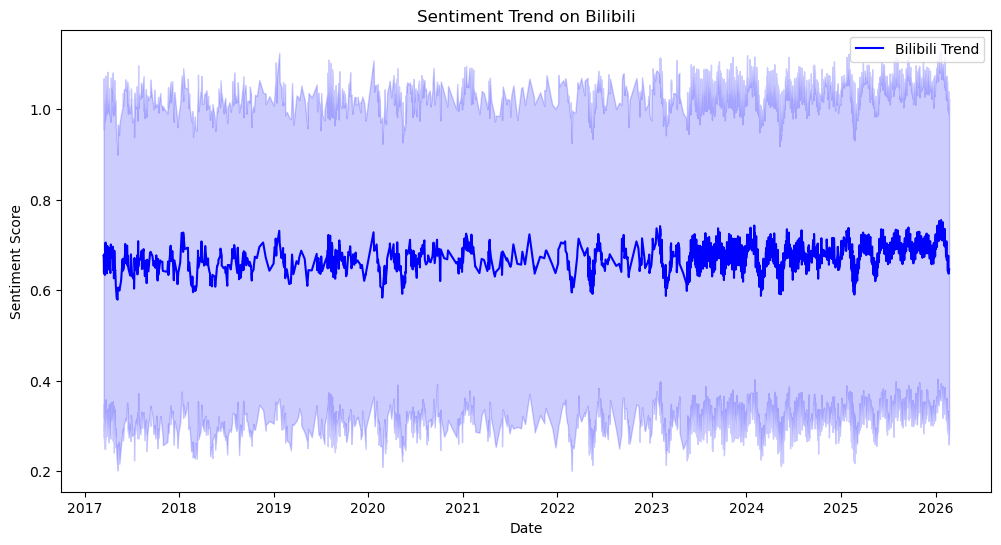

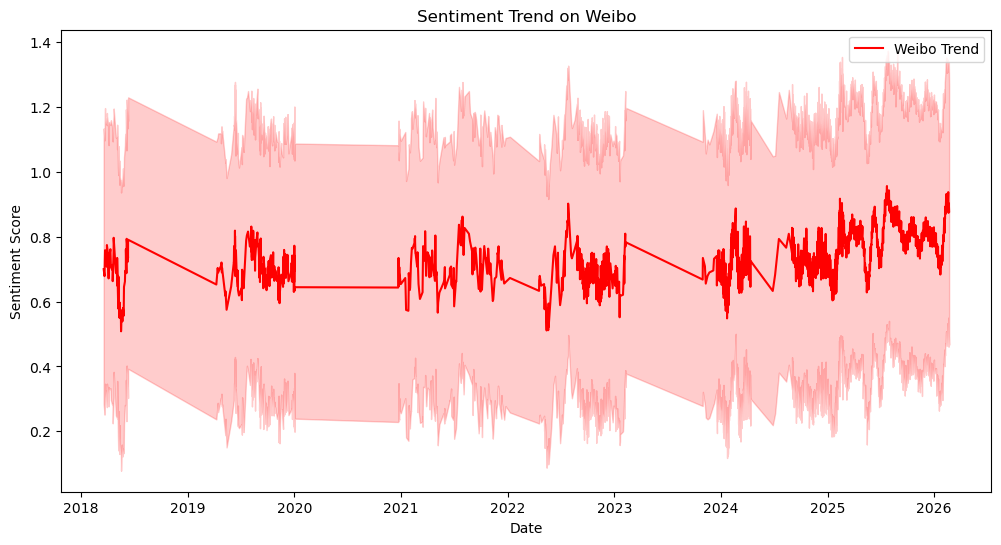

Bilibili Mann-Whitney U Test p-value: 0.31559
Weibo Mann-Whitney U Test p-value: 0.43863


"\n  Interpretation:\n- If p-value < 0.05: The sentiment distributions before and after the pandemic are significantly different.\n- If Weibo's p-value < 0.05 but Bilibili's p-value > 0.05: The pandemic had a stronger effect on sentiment change on Weibo than on Bilibili.\n- If neither platform shows significant change, then the pandemic likely had no substantial impact on anti-hero acceptance.\n"

In [6]:
# ========================== Step 1: Import Necessary Libraries ==========================

# Import necessary libraries
import pandas as pd # For data manipulation
import matplotlib.pyplot as plt # For data visualization
from prophet import Prophet # Facebook Prophet for time series forecasting
from scipy.stats import mannwhitneyu # Mann-Whitney U test for statistical comparison

# ========================== Step 2: Load and Prepare Data ==========================

# Define file paths for Bilibili and Weibo datasets
bilibili_path = r"C:\Users\wusiq\Desktop\2\bilibili_data_augmented.csv"
weibo_path = r"C:\Users\wusiq\Desktop\2\cleaned_sentiment_data.csv"

# Load datasets from CSV files
df_bilibili = pd.read_csv(bilibili_path)
df_weibo = pd.read_csv(weibo_path)

# Rename columns in the Weibo dataset for consistency with Bilibili
df_weibo.rename(columns={"Timestamp": "time", "Sentiment Score": "sentiment"}, inplace=True)

# Convert "time" column to datetime format for time series analysis
df_bilibili["time"] = pd.to_datetime(df_bilibili["time"])
df_weibo["time"] = pd.to_datetime(df_weibo["time"])

# Remove rows with missing sentiment values
df_bilibili = df_bilibili.dropna(subset=["sentiment"])
df_weibo = df_weibo.dropna(subset=["sentiment"])

# Confirm data columns after processing
print("Updated Weibo Columns:", df_weibo.columns)
print("Updated Bilibili Columns:", df_bilibili.columns)
# Log progress messages
print("Data successfully loaded and processed!")

# ========================== Step 3: Format Data for Prophet Model ==========================

# Prepare data for Prophet (renaming columns to Prophet's required format)
# Prophet requires:
# "ds" -> Datetime column (time series index)
# "y"  -> Target variable (sentiment score for forecasting)
df_bilibili_prophet = df_bilibili[["time", "sentiment"]].rename(columns={"time": "ds", "sentiment": "y"})
df_weibo_prophet = df_weibo[["time", "sentiment"]].rename(columns={"time": "ds", "sentiment": "y"})

# Aggregate data by date to calculate daily average sentiment scores
df_bilibili_prophet = df_bilibili_prophet.groupby("ds").mean().reset_index()
df_weibo_prophet = df_weibo_prophet.groupby("ds").mean().reset_index()

# ========================== Step 4: Train Prophet Models ==========================

# Initialize Prophet models for each platform
model_bilibili = Prophet()
model_weibo = Prophet()

# Train (fit) the models using historical sentiment data
model_bilibili.fit(df_bilibili_prophet)
model_weibo.fit(df_weibo_prophet)

# Create future prediction datasets (extending 365 days into the future)
future_bilibili = model_bilibili.make_future_dataframe(periods=365)
future_weibo = model_weibo.make_future_dataframe(periods=365)

# Generate sentiment forecasts using the trained models
forecast_bilibili = model_bilibili.predict(future_bilibili)
forecast_weibo = model_weibo.predict(future_weibo)

# ========================== Step 5: Visualizing Sentiment Trends ==========================

# Plot Bilibili sentiment trend over time
plt.figure(figsize=(12, 6))
plt.plot(forecast_bilibili["ds"], forecast_bilibili["yhat"], label="Bilibili Trend", color="blue")
plt.fill_between(forecast_bilibili["ds"], forecast_bilibili["yhat_lower"], forecast_bilibili["yhat_upper"], alpha=0.2, color="blue")
plt.title("Sentiment Trend on Bilibili")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()

# Plot Weibo sentiment trend over time
plt.figure(figsize=(12, 6))
plt.plot(forecast_weibo["ds"], forecast_weibo["yhat"], label="Weibo Trend", color="red")
plt.fill_between(forecast_weibo["ds"], forecast_weibo["yhat_lower"], forecast_weibo["yhat_upper"], alpha=0.2, color="red")
plt.title("Sentiment Trend on Weibo")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()

# ========================== Step 6: Statistical Comparison (Mann-Whitney U Test) ==========================

# Define the pandemic cutoff date (before and after the COVID-19 pandemic)
cutoff_date = "2020-01-01"

# Split sentiment data into pre-pandemic and post-pandemic periods
bilibili_pre = df_bilibili[df_bilibili["time"] < cutoff_date]["sentiment"]
bilibili_post = df_bilibili[df_bilibili["time"] >= cutoff_date]["sentiment"]

weibo_pre = df_weibo[df_weibo["time"] < cutoff_date]["sentiment"]
weibo_post = df_weibo[df_weibo["time"] >= cutoff_date]["sentiment"]

# Perform Mann-Whitney U test (non-parametric test) to compare sentiment distributions before and after the pandemic
bilibili_test = mannwhitneyu(bilibili_pre, bilibili_post, alternative="two-sided")
weibo_test = mannwhitneyu(weibo_pre, weibo_post, alternative="two-sided")

# Print statistical test results
print(f"Bilibili Mann-Whitney U Test p-value: {bilibili_test.pvalue:.5f}")
print(f"Weibo Mann-Whitney U Test p-value: {weibo_test.pvalue:.5f}")

"""
======================================= Interpretation of Results =======================================

- The Mann-Whitney U test determines whether the sentiment scores before and after the pandemic have significantly different distributions.

- **If p-value < 0.05**: There is a significant difference in sentiment distributions, suggesting that sentiment towards anti-hero characters changed significantly after the pandemic.
- **If Weibo's p-value < 0.05 but Bilibili's p-value > 0.05**: This suggests that the pandemic had a stronger impact on sentiment changes on Weibo compared to Bilibili.
- **If neither platform shows a significant change (p-value > 0.05)**: This suggests that the pandemic did not cause substantial shifts in the perception of anti-hero characters.

=========================================================================================================
"""

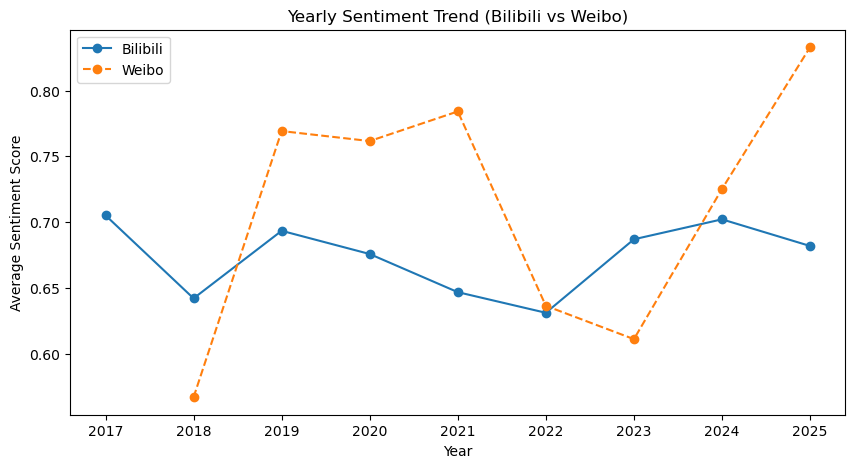

In [7]:
# ========================== Step 1: Calculate Yearly Average Sentiment Scores ==========================

# Extract the year from the "time" column for each platform
df_bilibili["year"] = df_bilibili["time"].dt.year
df_weibo["year"] = df_weibo["time"].dt.year
# Compute the average sentiment score for each year
bilibili_yearly = df_bilibili.groupby("year")["sentiment"].mean()
weibo_yearly = df_weibo.groupby("year")["sentiment"].mean()

# ========================== Step 2: Visualizing Sentiment Trends Over Years ==========================

# Set up a figure for sentiment trend visualization
plt.figure(figsize=(10, 5))
# Plot Bilibili sentiment trend over the years
plt.plot(bilibili_yearly.index, bilibili_yearly.values, marker="o", label="Bilibili")
# Plot Weibo sentiment trend over the years (dashed line for differentiation)
plt.plot(weibo_yearly.index, weibo_yearly.values, marker="o", label="Weibo", linestyle="dashed")
# Add labels and title for clarity
plt.xlabel("Year") # X-axis represents years
plt.ylabel("Average Sentiment Score") # Y-axis represents average sentiment scores
plt.title("Yearly Sentiment Trend (Bilibili vs Weibo)") # Chart title
# Add a legend to distinguish between Bilibili and Weibo sentiment trends
plt.legend()
# Display the plot
plt.show()


In [10]:
# ========================== Step 1: Define Threshold for Extreme Sentiment ==========================

# Define the threshold value for highly positive sentiment
# Any sentiment score above this value is considered "extremely positive"
threshold = 0.9  # Consider sentiment >0.9 as highly positive

# ========================== Step 2: Compute Extreme Sentiment Proportions ==========================

# Calculate the proportion of extreme sentiment (>0.9) in each period
# The `.mean()` function gives the proportion of rows where the condition is True

# Pre-Pandemic Period (before 2019-12-30)
extreme_pre = (pre_pandemic["sentiment"] > threshold).mean()

# During-Pandemic Period (between 2019-12-30 and mid-pandemic)
extreme_during = (during_pandemic["sentiment"] > threshold).mean()

# Post-Pandemic Period (after mid-pandemic period)
extreme_post = (post_pandemic["sentiment"] > threshold).mean()

# ========================== Step 3: Display Results ==========================

# Print the percentage of extreme positive sentiment for each period
# The "{:.2%}" format converts the fraction to a percentage (e.g., 0.153 → 15.3%)
print(f"Extreme Positive Sentiment Pre-Pandemic: {extreme_pre:.2%}")
print(f"Extreme Positive Sentiment During-Pandemic: {extreme_during:.2%}")
print(f"Extreme Positive Sentiment Post-Pandemic: {extreme_post:.2%}")


Extreme Positive Sentiment Pre-Pandemic: 34.05%
Extreme Positive Sentiment During-Pandemic: 31.29%
Extreme Positive Sentiment Post-Pandemic: 35.54%


In [11]:
# ========================== Step 1: Construct Contingency Table ==========================

# Import Chi-square test function from scipy
from scipy.stats import chi2_contingency

# Create a contingency table (2x2 matrix) for the Chi-square test
# Row 1: Pre-Pandemic (number of extreme positive vs. non-extreme positive sentiment)
# Row 2: Post-Pandemic (number of extreme positive vs. non-extreme positive sentiment)
contingency_table = [
    # [Number of extreme positive sentiment (>0.9), Number of non-extreme sentiment (≤0.9)]
    [pre_pandemic["sentiment"].gt(0.9).sum(), len(pre_pandemic) - pre_pandemic["sentiment"].gt(0.9).sum()],
    [post_pandemic["sentiment"].gt(0.9).sum(), len(post_pandemic) - post_pandemic["sentiment"].gt(0.9).sum()]
]

# ========================== Step 2: Perform Chi-Square Test ==========================

# Conduct the Chi-square test for independence
# - `chi2`: Chi-square test statistic
# - `p`: P-value indicating statistical significance
# - `_`: Degrees of freedom (not used here)
# - `_`: Expected frequency table (not used here
chi2, p, _, _ = chi2_contingency(contingency_table)
# ========================== Step 3: Display Results ==========================

# Print the Chi-square test statistic and p-value
print(f"Chi-square test statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")

# ========================== Step 4: Interpretation of Results ==========================

# Interpret the p-value:
# - If p < 0.05, the difference in extreme sentiment distribution is statistically significant.
# - If p >= 0.05, there is no significant difference before and after the pandemic.
if p < 0.05:
    print("✅ There is a statistically significant increase in extreme positive sentiment after the pandemic.")
else:
    print("❌ No statistically significant change in extreme positive sentiment after the pandemic.")


Chi-square test statistic: 0.9386
P-value: 0.3326
❌ No statistically significant change in extreme positive sentiment after the pandemic.


In [13]:
# ========================== Step 1: Import Necessary Libraries ==========================
import pandas as pd
from scipy.stats import chi2_contingency

# ========================== Step 2: Load and Preprocess Datasets ==========================

# Define file paths for Bilibili and Weibo sentiment datasets
bilibili_path = "C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_augmented.csv"
weibo_path = "C:\\Users\\wusiq\\Desktop\\2\\cleaned_sentiment_data.csv"

# Load datasets from CSV files
df_bilibili = pd.read_csv(bilibili_path)
df_weibo = pd.read_csv(weibo_path)

# Rename columns in Weibo dataset for consistency
df_weibo.rename(columns={"Timestamp": "time", "Sentiment Score": "sentiment"}, inplace=True)


# Convert "time" column to datetime format for both datasets
df_bilibili["time"] = pd.to_datetime(df_bilibili["time"])
df_weibo["time"] = pd.to_datetime(df_weibo["time"])

# ========================== Step 3: Define Time Periods for Comparison ==========================

# Define pandemic period boundaries:
# - Pre-pandemic: Before December 1, 2019
# - Post-pandemic: Starting from January 1, 2023
pre_pandemic_end = "2019-12-01"
post_pandemic_start = "2023-01-01"

# Filter sentiment data into pre-pandemic and post-pandemic periods
pre_bilibili = df_bilibili[df_bilibili["time"] < pre_pandemic_end]
post_bilibili = df_bilibili[df_bilibili["time"] >= post_pandemic_start]

pre_weibo = df_weibo[df_weibo["time"] < pre_pandemic_end]
post_weibo = df_weibo[df_weibo["time"] >= post_pandemic_start]

# ========================== Step 4: Compute Extreme Positive Sentiment Ratios ==========================

# Compute the proportion of extreme positive sentiment (sentiment > 0.9) for both platforms
bilibili_pre_ratio = (pre_bilibili["sentiment"] > 0.9).mean()
bilibili_post_ratio = (post_bilibili["sentiment"] > 0.9).mean()

weibo_pre_ratio = (pre_weibo["sentiment"] > 0.9).mean()
weibo_post_ratio = (post_weibo["sentiment"] > 0.9).mean()

# Print extreme sentiment ratios before and after the pandemic
print(f"Bilibili Extreme Positive Sentiment (Pre-Pandemic): {bilibili_pre_ratio:.2%}")
print(f"Bilibili Extreme Positive Sentiment (Post-Pandemic): {bilibili_post_ratio:.2%}")

print(f"Weibo Extreme Positive Sentiment (Pre-Pandemic): {weibo_pre_ratio:.2%}")
print(f"Weibo Extreme Positive Sentiment (Post-Pandemic): {weibo_post_ratio:.2%}")

# ========================== Step 5: Perform Chi-Square Test for Statistical Significance ==========================

# Construct contingency table for Bilibili
contingency_bilibili = [
    [pre_bilibili["sentiment"].gt(0.9).sum(), len(pre_bilibili) - pre_bilibili["sentiment"].gt(0.9).sum()],
    [post_bilibili["sentiment"].gt(0.9).sum(), len(post_bilibili) - post_bilibili["sentiment"].gt(0.9).sum()]
]

# Conduct Chi-square test for Bilibili
chi2_bilibili, p_bilibili, _, _ = chi2_contingency(contingency_bilibili)


# Construct contingency table for Weibo
contingency_weibo = [
    [pre_weibo["sentiment"].gt(0.9).sum(), len(pre_weibo) - pre_weibo["sentiment"].gt(0.9).sum()],
    [post_weibo["sentiment"].gt(0.9).sum(), len(post_weibo) - post_weibo["sentiment"].gt(0.9).sum()]
]
# Conduct Chi-square test for Weibo
chi2_weibo, p_weibo, _, _ = chi2_contingency(contingency_weibo)

# ========================== Step 6: Display Chi-Square Test Results ==========================
print("\n Chi-square Test Results:")
print(f"Bilibili: Chi-square = {chi2_bilibili:.4f}, P-value = {p_bilibili:.4f}")
print(f"Weibo: Chi-square = {chi2_weibo:.4f}, P-value = {p_weibo:.4f}")

# ========================== Step 7: Interpretation of Statistical Results ==========================

# Interpretation based on p-values (significance level: 0.05)
if p_bilibili < 0.05 and p_weibo >= 0.05:
    print("✅ Bilibili shows a significant increase in extreme positive sentiment after the pandemic.")
elif p_weibo < 0.05 and p_bilibili >= 0.05:
    print("✅ Weibo shows a significant increase in extreme positive sentiment after the pandemic.")
elif p_bilibili < 0.05 and p_weibo < 0.05:
    print("✅ Both platforms show significant increases in extreme positive sentiment after the pandemic.")
else:
    print("❌ No statistically significant change in extreme positive sentiment on either platform.")


Bilibili Extreme Positive Sentiment (Pre-Pandemic): 34.05%
Bilibili Extreme Positive Sentiment (Post-Pandemic): 35.49%
Weibo Extreme Positive Sentiment (Pre-Pandemic): 51.24%
Weibo Extreme Positive Sentiment (Post-Pandemic): 62.03%

 Chi-square Test Results:
Bilibili: Chi-square = 0.8667, P-value = 0.3519
Weibo: Chi-square = 16.9599, P-value = 0.0000
✅ Weibo shows a significant increase in extreme positive sentiment after the pandemic.


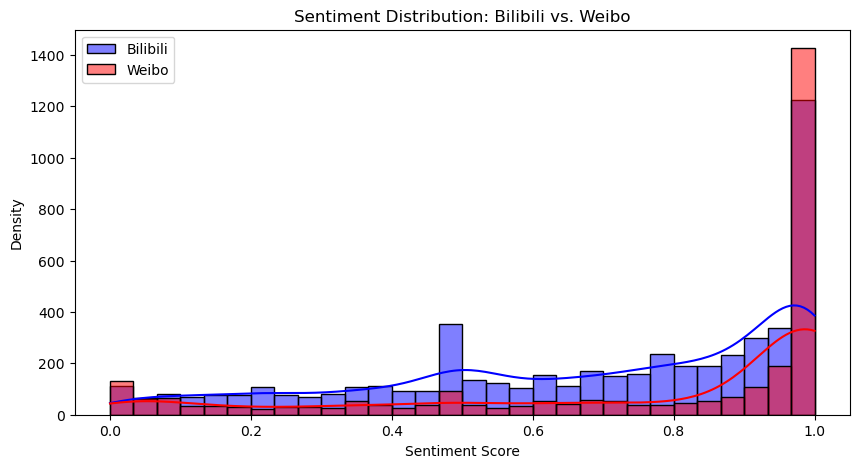

Kolmogorov-Smirnov Test Results:
KS Statistic = 0.2609, P-value = 0.0000
✅ Weibo and Bilibili have significantly different sentiment distributions.


In [14]:
# ========================== Step 1: Import Necessary Libraries ==========================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# ========================== Step 2: Load and Preprocess Datasets ==========================

# Define file paths for Bilibili and Weibo sentiment datasets
bilibili_path = "C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_augmented.csv"
weibo_path = "C:\\Users\\wusiq\\Desktop\\2\\cleaned_sentiment_data.csv"

# Load datasets from CSV files
df_bilibili = pd.read_csv(bilibili_path)
df_weibo = pd.read_csv(weibo_path)

# Rename columns in Weibo dataset for consistency
df_weibo.rename(columns={"Timestamp": "time", "Sentiment Score": "sentiment"}, inplace=True)

# Convert "time" column to datetime format for both datasets
df_bilibili["time"] = pd.to_datetime(df_bilibili["time"])
df_weibo["time"] = pd.to_datetime(df_weibo["time"])

# ========================== Step 3: Visualizing Sentiment Score Distributions ==========================

# Set up figure size for better readability
plt.figure(figsize=(10, 5))

# Plot sentiment distributions using kernel density estimation (KDE) for smooth visualization
sns.histplot(df_bilibili["sentiment"], bins=30, kde=True, color="blue", label="Bilibili", alpha=0.5)
sns.histplot(df_weibo["sentiment"], bins=30, kde=True, color="red", label="Weibo", alpha=0.5)
# Add title and labels for clarity
plt.legend()
plt.title("Sentiment Distribution: Bilibili vs. Weibo")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")

# Display the plot
plt.show()

# ========================== Step 4: Kolmogorov-Smirnov Test for Distribution Differences ==========================

# Perform the Kolmogorov-Smirnov (KS) test to check if the sentiment score distributions differ
ks_stat, p_value = ks_2samp(df_bilibili["sentiment"].dropna(), df_weibo["sentiment"].dropna())

# Print statistical test results
print(f"Kolmogorov-Smirnov Test Results:")
print(f"KS Statistic = {ks_stat:.4f}, P-value = {p_value:.4f}")

# ========================== Step 5: Interpretation of KS Test Results ==========================

# Interpretation based on p-value (significance level: 0.05)
if p_value < 0.05:
    print("✅ Weibo and Bilibili have significantly different sentiment distributions.")
else:
    print("❌ No significant difference in sentiment distributions between Weibo and Bilibili.")


09:12:37 - cmdstanpy - INFO - Chain [1] start processing
09:12:37 - cmdstanpy - INFO - Chain [1] done processing


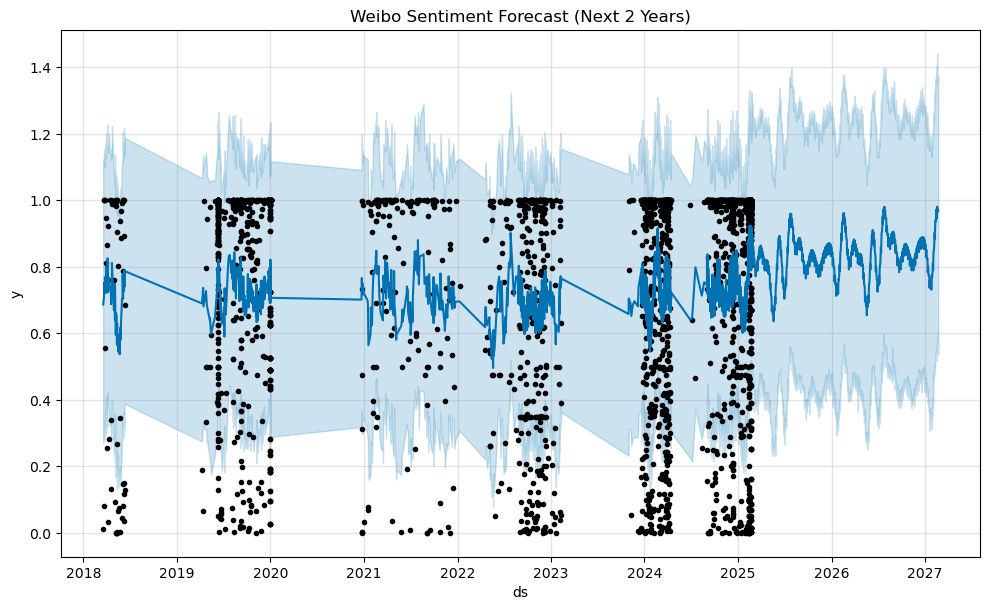

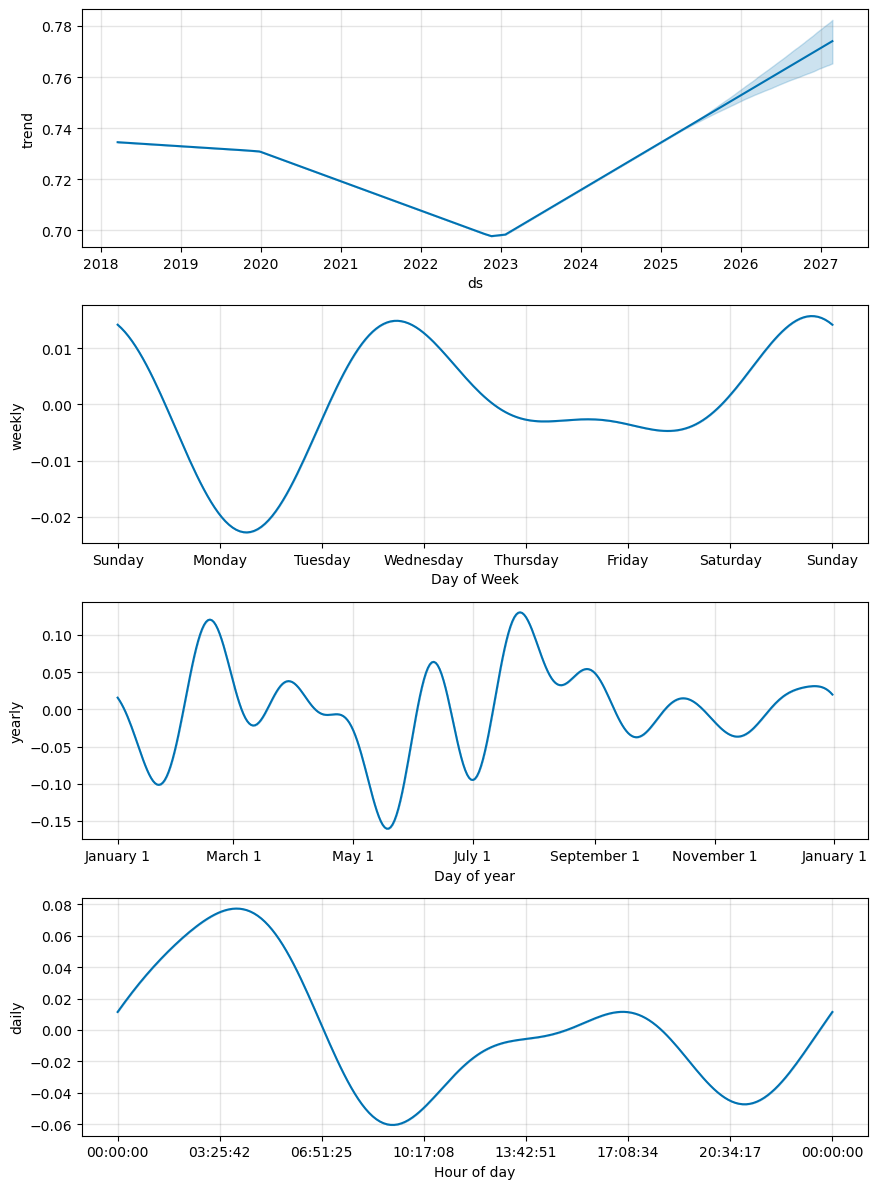

In [16]:
# ========================== Step 1: Import Necessary Libraries ==========================

# Import Prophet for time-series forecasting
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# ========================== Step 2: Load and Preprocess Weibo Sentiment Data ==========================

# Define the file path for the cleaned Weibo sentiment dataset
weibo_path = "C:\\Users\\wusiq\\Desktop\\2\\cleaned_sentiment_data.csv"

# Load the Weibo dataset from CSV file
df_weibo = pd.read_csv(weibo_path)

# Rename columns for consistency with Prophet's expected format
df_weibo.rename(columns={"Timestamp": "time", "Sentiment Score": "sentiment"}, inplace=True)

# Convert the "time" column to datetime format
df_weibo["time"] = pd.to_datetime(df_weibo["time"])

# ========================== Step 3: Prepare Data for Prophet Forecasting ==========================

# Select only the necessary columns and rename them to Prophet's required format:
# "ds" (date/time) and "y" (values to predict)
df_weibo_prophet = df_weibo[["time", "sentiment"]].rename(columns={"time": "ds", "sentiment": "y"})
# ========================== Step 4: Train Prophet Model ==========================

# Initialize a Prophet model for time-series forecasting
model = Prophet()

# Train (fit) the model using Weibo sentiment data
model.fit(df_weibo_prophet)

# ========================== Step 5: Make Future Predictions (Next 2 Years) ==========================

# Create a dataframe that extends 730 days (~2 years) into the future
future = model.make_future_dataframe(periods=730)  # 730 days = ~2 years

# Generate predictions using the trained model
forecast = model.predict(future)

# ========================== Step 6: Visualize the Forecasted Sentiment Trend ==========================

# Plot the sentiment forecast
fig = model.plot(forecast)
# Add a title for clarity
plt.title("Weibo Sentiment Forecast (Next 2 Years)")
# Display the plot
plt.show()

# ========================== Step 7: Visualize the Trend Components ==========================

# Plot the individual trend components (overall trend, seasonal patterns)
fig2 = model.plot_components(forecast)
# Display the component analysis
plt.show()


C:\Users\wusiq\AppData\Local\Temp\ipykernel_43520\1825952615.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_pandemic['clean_text'] = pre_pandemic['text'].apply(clean_text).apply(tokenize)
C:\Users\wusiq\AppData\Local\Temp\ipykernel_43520\1825952615.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_pandemic['clean_text'] = post_pandemic['text'].apply(clean_text).apply(tokenize)


Model Accuracy: 0.8379
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.50      0.65       414
         1.0       0.82      0.98      0.89       986

    accuracy                           0.84      1400
   macro avg       0.87      0.74      0.77      1400
weighted avg       0.85      0.84      0.82      1400



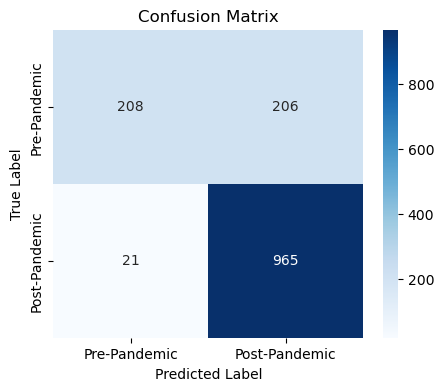


Chi-square Test Results:
Chi-square statistic: 21.6434
P-value: 0.0000
✅ Significant change in sentiment after the pandemic.


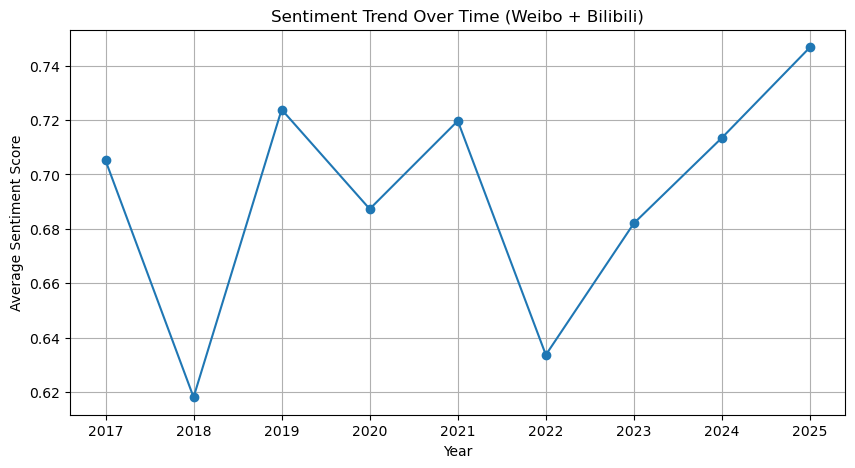

In [34]:
# ========================== Step 1: Import Necessary Libraries ==========================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import chi2_contingency
import jieba

# ========================== Step 2: Load and Merge Data ==========================

# Define file paths for Weibo and Bilibili datasets
weibo_path = "C:\\Users\\wusiq\\Desktop\\2\\cleaned_sentiment_data.csv"
bilibili_path = "C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_augmented.csv"

# Load datasets from CSV files
df_weibo = pd.read_csv(weibo_path)
df_bilibili = pd.read_csv(bilibili_path)

# Standardizing column names for consistency
df_weibo.rename(columns={'评论': 'text', 'Timestamp': 'date', 'Sentiment Score': 'sentiment'}, inplace=True)
df_bilibili.rename(columns={'time': 'date'}, inplace=True)

# Selecting relevant columns
df_weibo = df_weibo[['text', 'date', 'sentiment']]
df_bilibili = df_bilibili[['text', 'date', 'sentiment']]

# Merge both datasets into one combined dataframe
df = pd.concat([df_weibo, df_bilibili], ignore_index=True)

# Convert 'date' column to datetime format for time-based analysis
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Define pandemic periods for comparison
pre_pandemic = df[df['date'] < '2019-12']
post_pandemic = df[df['date'] >= '2023-01']

# ========================== Step 3: Text Preprocessing (Cleaning + Tokenization) ==========================
def clean_text(text):
    """Remove special characters and keep only Chinese characters."""
    text = re.sub(r'[^\u4e00-\u9fa5]', '', str(text))
    return text

def tokenize(text):
    """Tokenize Chinese text using jieba and remove single-character words."""
    return ' '.join([word for word in jieba.lcut(text) if len(word) > 1])

# Apply text cleaning and tokenization
pre_pandemic['clean_text'] = pre_pandemic['text'].apply(clean_text).apply(tokenize)
post_pandemic['clean_text'] = post_pandemic['text'].apply(clean_text).apply(tokenize)

# ========================== Step 4: Feature Extraction with TF-IDF ==========================

# Combine all text for vectorization
all_text = pd.concat([pre_pandemic['clean_text'], post_pandemic['clean_text']], ignore_index=True)

# Initialize TF-IDF vectorizer (limit features to 5000 for efficiency)
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features to 5000 for efficiency
X = vectorizer.fit_transform(all_text)

# Assigning labels for classification (0 = Pre-Pandemic, 1 = Post-Pandemic)
y = np.concatenate([np.zeros(len(pre_pandemic)), np.ones(len(post_pandemic))])

# Splitting data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========================== Step 5: Train Logistic Regression Model ==========================

# Initialize and train a Logistic Regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# ========================== Step 6: Model Evaluation ==========================

# Make predictions on test set
y_pred = model.predict(X_test)

# Compute accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Print classification report (precision, recall, F1-score)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate confusion matrix visualization
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Pre-Pandemic", "Post-Pandemic"], yticklabels=["Pre-Pandemic", "Post-Pandemic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ========================== Step 7: Statistical Significance Testing (Chi-Square Test) ==========================

# Define extreme sentiment threshold (e.g., sentiment score > 0.8 is considered highly positive)
threshold = 0.8  
# Count extreme positive sentiment instances before and after the pandemic
pre_positive = (pre_pandemic['sentiment'] > threshold).sum()
post_positive = (post_pandemic['sentiment'] > threshold).sum()

# Create contingency table for Chi-Square Test
contingency_table = np.array([[pre_positive, len(pre_pandemic) - pre_positive],
                              [post_positive, len(post_pandemic) - post_positive]])

# Perform Chi-Square Test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Print results
print("\nChi-square Test Results:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation of results
if p_value < 0.05:
    print("✅ Significant change in sentiment after the pandemic.")
else:
    print("❌ No significant change in sentiment after the pandemic.")

# ========================== Step 8: Visualizing Sentiment Trends Over Time ==========================

# Extract yearly average sentiment scores for trend analysis
df['year'] = df['date'].dt.year
yearly_sentiment = df.groupby("year")["sentiment"].mean()

# Generate time-series plot of sentiment trends
plt.figure(figsize=(10, 5))
plt.plot(yearly_sentiment.index, yearly_sentiment.values, marker="o", linestyle="-")
plt.xlabel("Year")
plt.ylabel("Average Sentiment Score")
plt.title("Sentiment Trend Over Time (Weibo + Bilibili)")
plt.grid()
plt.show()
